Saving combined_emotion.csv to combined_emotion (2).csv
Dataset Shape: (422746, 2)

Detected Columns → Text: sentence , Emotion: emotion
emotion
joy        143067
sad        121187
anger       59317
fear        49649
love        34554
suprise     14972
Name: count, dtype: int64

Encoded Emotions: {'anger': 0, 'fear': 1, 'joy': 2, 'love': 3, 'sad': 4, 'suprise': 5}


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/4
2114/2114 ━━━━━━━━━━━━━━━━━━━━ 566s 264ms/step - accuracy: 0.7424 - loss: 0.6682 - val_accuracy: 0.9374 - val_loss: 0.1037
Epoch 2/4
2114/2114 ━━━━━━━━━━━━━━━━━━━━ 561s 265ms/step - accuracy: 0.9351 - loss: 0.1192 - val_accuracy: 0.9403 - val_loss: 0.0924
Epoch 3/4
2114/2114 ━━━━━━━━━━━━━━━━━━━━ 549s 259ms/step - accuracy: 0.9395 - loss: 0.0986 - val_accuracy: 0.9408 - val_loss: 0.0929

✅ Test Accuracy: 0.9407


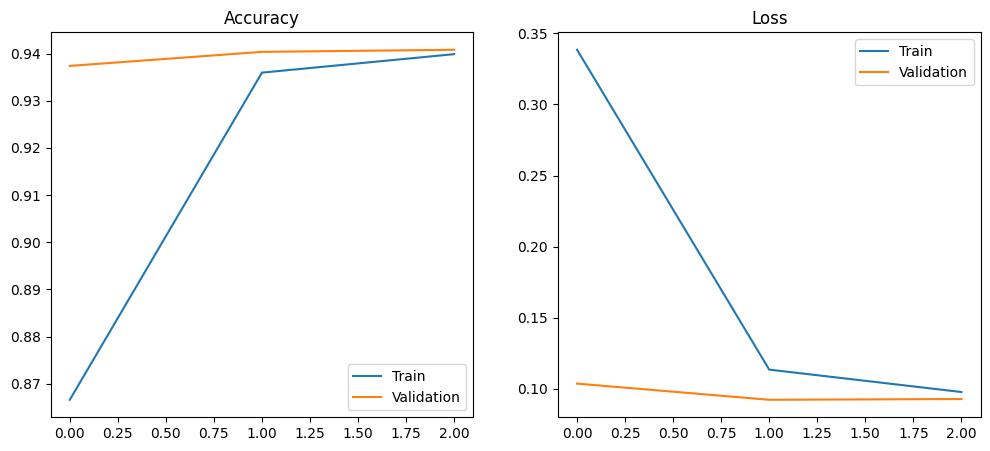


🗣 Text: I am feeling so happy today!
Predicted Emotion: anger (0.38 confidence)

🗣 Text: This makes me sad.
Predicted Emotion: anger (0.41 confidence)

🗣 Text: I am very angry about this!
Predicted Emotion: anger (0.42 confidence)

💾 Model, tokenizer, and label encoder saved successfully!


In [ ]:
# ================================================
# 💬 FAST EMOTION DETECTION USING RNN (LSTM)
# ================================================

# Step 1: Install dependencies
!pip install tensorflow numpy pandas scikit-learn matplotlib --quiet

# Step 2: Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# Step 3: Upload dataset
from google.colab import files
uploaded = files.upload()  # upload your combined_emotion.csv

# Step 4: Load dataset
df = pd.read_csv("combined_emotion.csv")
print("Dataset Shape:", df.shape)
df.head()

# Step 5: Detect text and emotion columns automatically
possible_text_cols = ["text", "sentence", "content", "tweet", "review", "message"]
possible_label_cols = ["label", "emotion", "target", "category"]

text_col = next((c for c in df.columns if c.lower() in possible_text_cols), df.columns[0])
label_col = next((c for c in df.columns if c.lower() in possible_label_cols), df.columns[1])

df = df[[text_col, label_col]].dropna().rename(columns={text_col: "text", label_col: "emotion"})
print("\nDetected Columns → Text:", text_col, ", Emotion:", label_col)
print(df["emotion"].value_counts())

# Step 6: Encode labels
le = LabelEncoder()
df["emotion_encoded"] = le.fit_transform(df["emotion"])
print("\nEncoded Emotions:", dict(zip(le.classes_, range(len(le.classes_)))))

# Step 7: Split dataset
X_train, X_test, y_train, y_test = train_test_split(
    df["text"], df["emotion_encoded"], test_size=0.2, random_state=42, stratify=df["emotion_encoded"]
)

# Step 8: Tokenization and padding
max_words = 6000   # reduced vocabulary for speed
max_len = 80       # shorter sequence length

tokenizer = Tokenizer(num_words=max_words, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

X_train_pad = pad_sequences(X_train_seq, maxlen=max_len, padding='post', truncating='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len, padding='post', truncating='post')

# Step 9: Build a smaller, faster LSTM model
num_classes = len(le.classes_)

model = Sequential([
    Embedding(max_words, 64, input_length=max_len),
    Bidirectional(LSTM(64, dropout=0.2, recurrent_dropout=0.2, return_sequences=False)),
    Dense(32, activation='relu'),
    Dropout(0.3),
    Dense(num_classes, activation='softmax')
])

model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=Adam(learning_rate=2e-3),
    metrics=['accuracy']
)

model.summary()

# Step 10: Train faster with early stopping
es = EarlyStopping(monitor='val_loss', patience=1, restore_best_weights=True)

history = model.fit(
    X_train_pad, y_train,
    validation_split=0.2,
    epochs=4,             # fewer epochs
    batch_size=128,       # larger batch size
    callbacks=[es],
    verbose=1
)

# Step 11: Evaluate
loss, acc = model.evaluate(X_test_pad, y_test, verbose=0)
print(f"\n✅ Test Accuracy: {acc:.4f}")

# Step 12: Plot accuracy/loss
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title('Accuracy')
plt.legend()
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Loss')
plt.legend()
plt.show()

# Step 13: Predict custom text
def predict_emotion(text):
    seq = tokenizer.texts_to_sequences([text])
    pad = pad_sequences(seq, maxlen=max_len)
    pred = model.predict(pad, verbose=0)[0]
    emotion = le.classes_[np.argmax(pred)]
    print(f"\n🗣 Text: {text}")
    print(f"Predicted Emotion: {emotion} ({np.max(pred):.2f} confidence)")

# Examples
predict_emotion("I am feeling so happy today!")
predict_emotion("This makes me sad.")
predict_emotion("I am very angry about this!")

# Step 14: Save model and tokenizer
model.save("fast_emotion_rnn_model.h5")

import pickle
with open("tokenizer.pkl", "wb") as f:
    pickle.dump(tokenizer, f)
with open("label_encoder.pkl", "wb") as f:
    pickle.dump(le, f)

print("\n💾 Model, tokenizer, and label encoder saved successfully!")
